<a href="https://colab.research.google.com/github/Matteo-Candi/Fine-Tuning-with-LoRA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
from transformers import set_seed, BertTokenizer, TFBertModel, TFBertForSequenceClassification, TFBertMainLayer
from datasets import load_dataset, concatenate_datasets
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import math

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

# Dataset and Preprocessing

In [ ]:
dataset = load_dataset("go_emotions", "simplified").shuffle(seed=17)
labels = dataset['train'].features['labels'].feature.names
dataset = dataset.remove_columns('id')


def filter_labels(example):
    return len(example['labels']) < 2

for split in dataset.keys():
    dataset[split] = dataset[split].filter(filter_labels)

model_name = "bert-base-cased"
num_labels = 28

tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def get_df_summary(df):
    label_column = df['labels'].to_list()
    flatten_col = list(itertools.chain(*label_column))
    freq_dict = dict(Counter(flatten_col))
    freq_list = list(dict(sorted(freq_dict.items())).values())
    rel_freq_list = [el / sum(freq_list) * 100 for el in freq_list]

    return rel_freq_list

In [ ]:
df_train = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

# Get dataframes info.
train_freq = get_df_summary(df_train)
val_freq = get_df_summary(df_val)
test_freq = get_df_summary(df_test)

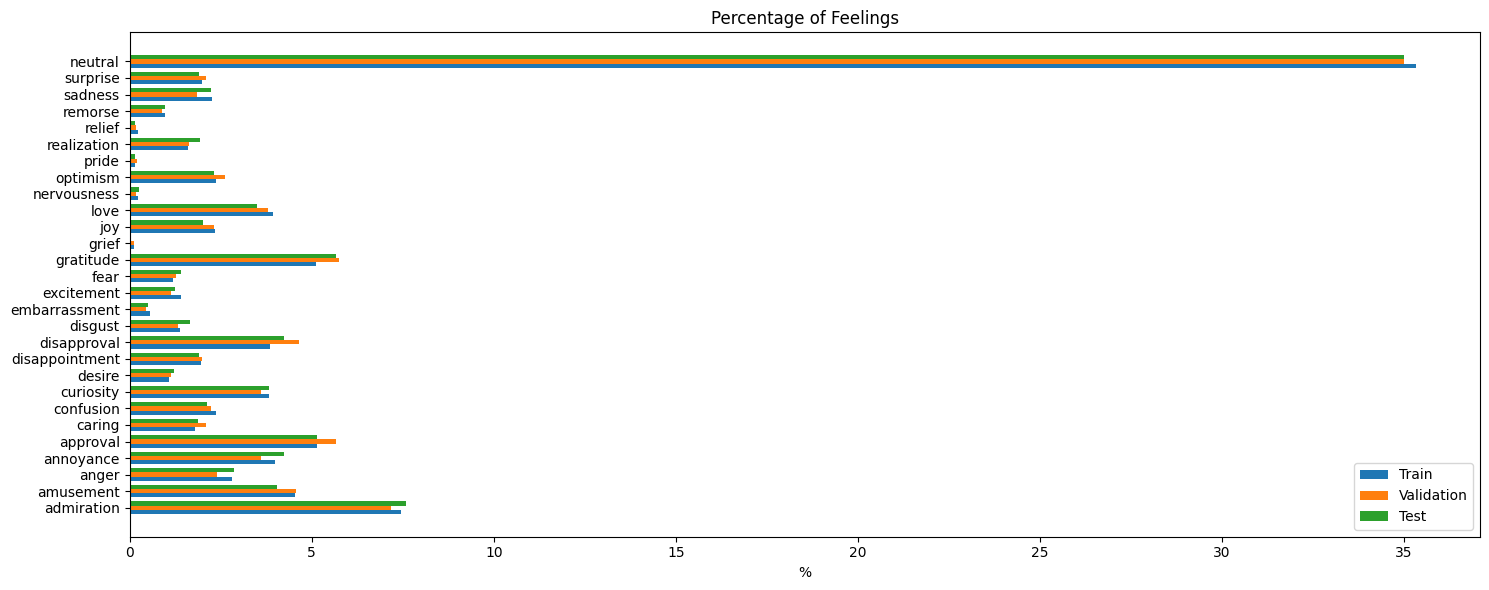

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.25
index = np.arange(len(train_freq))
bars_train = ax.barh(index, train_freq, bar_width, label='Train')
bars_val = ax.barh(index + bar_width, val_freq, bar_width, label='Validation')
bars_test = ax.barh(index + 2*bar_width, test_freq, bar_width, label='Test')
plt.xlabel('%')
plt.title('Percentage of Feelings')
plt.yticks(index + bar_width, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def tokenizer_func(text):
    '''
    Tokenizing the text using the BERT tokenizer.
    '''
    # Checking there is just one tokenization up to 316 and the second longest one is 120.
    # token_lengths = [sum(tokenized_train[i][0] != 0) for i in range(len(tokenized_train))]
    return tokenizer(text, padding = 'max_length', max_length = 120, return_tensors = "tf", truncation=True)

def one_hot_func(indices):
    '''
    Converting a value in one hot encode vector.
    '''
    one_hot_encoding = np.zeros(28, dtype=int)
    one_hot_encoding[indices] = 1
    return {'labels': one_hot_encoding}

def process_dataset_func(dataset):
    '''
    Processing the dataset to make it readable from the model.
    '''
    processed_dataset = dataset.map(lambda x: tokenizer_func(x['text']))
    processed_dataset = processed_dataset.map(lambda x: one_hot_func(x['labels']))
    processed_dataset = processed_dataset.remove_columns('text')
    return processed_dataset

In [ ]:
dataset = process_dataset_func(dataset)

Map:   0%|          | 0/36308 [00:00<?, ? examples/s]

Map:   0%|          | 0/4548 [00:00<?, ? examples/s]

Map:   0%|          | 0/4590 [00:00<?, ? examples/s]

Map:   0%|          | 0/36308 [00:00<?, ? examples/s]

Map:   0%|          | 0/4548 [00:00<?, ? examples/s]

Map:   0%|          | 0/4590 [00:00<?, ? examples/s]

In [ ]:
batch_size = 32
tf_dataset_train = tf.data.Dataset.from_tensor_slices((dataset['train']['input_ids'], dataset['train']['labels'])).batch(batch_size)
tf_dataset_validation = tf.data.Dataset.from_tensor_slices((dataset['validation']['input_ids'], dataset['validation']['labels'])).batch(batch_size)
tf_dataset_test = tf.data.Dataset.from_tensor_slices((dataset['test']['input_ids'], dataset['test']['labels'])).batch(batch_size)

# Reshape labels to match the model output.
tf_dataset_train = tf_dataset_train.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_validation = tf_dataset_validation.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_test = tf_dataset_test.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))

# Models

## Base model

In [ ]:
class BaseModel(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(BaseModel, self).__init__()
        self.num_labels = num_labels

        # When importing the model some weigths have different initialization states.
        set_seed(17)
        self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = self.num_labels)
        self.softmax = tf.keras.layers.Activation('softmax')


    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)[0]
        model_output = self.softmax(logits)


        return model_output

In [ ]:
stop

In [ ]:
base_model = BaseModel(model_name, num_labels)
base_model.model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_455 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108331804 (413.25 MB)
Trainable params: 108331804 (413.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_epochs = 5

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

base_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)


base_model_history = base_model.fit(tf_dataset_train, validation_data=tf_dataset_validation, epochs=num_epochs, batch_size=batch_size)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
1135/1135 [==============================] - 978s 806ms/step - loss: 1.6934 - accuracy: 0.5419 - val_loss: 1.3562 - val_accuracy: 0.6102
Epoch 2/5
1135/1135 [==============================] - 913s 804ms/step - loss: 1.0871 - accuracy: 0.6727 - val_loss: 1.3531 - val_accuracy: 0.6025
Epoch 3/5
1135/1135 [==============================] - 914s 805ms/step - loss: 0.6283 - accuracy: 0.8094 - val_loss: 1.6252 - val_accuracy: 0.5772
Epoch 4/5
1135/1135 [==============================] - 895s 789ms/step - loss: 0.3395 - accuracy: 0.8971 - val_loss: 1.8789 - val_accuracy: 0.5851
Epoch 5/5
1135/1135 [==============================] - 892s 786ms/step - loss: 0.1989 - accuracy: 0.9394 - val_loss: 2.1411 - val_accuracy: 0.5772


In [ ]:
def plot_accuracy_and_loss(data):
    epochs = range(1, len(data['loss']) + 1)

    # Plotting losses
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, data['accuracy'], label='Training')
    plt.plot(epochs, data['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(1, len(epochs)+1))

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, data['loss'], label='Training')
    plt.plot(epochs, data['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(1, len(epochs)+1))

    plt.tight_layout()
    plt.show()

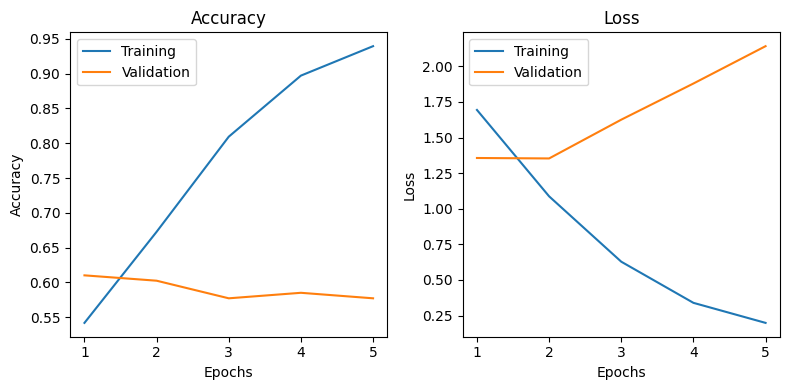

In [ ]:
base_model_data = {'loss': [1.6934291124343872,
  1.0871013402938843,
  0.6282956004142761,
  0.3395499289035797,
  0.19886009395122528],
 'accuracy': [0.5418640375137329,
  0.6727442741394043,
  0.809380829334259,
  0.8971301317214966,
  0.939434826374054],
 'val_loss': [1.3562015295028687,
  1.3530546426773071,
  1.6251964569091797,
  1.878911018371582,
  2.1410646438598633],
 'val_accuracy': [0.6101583242416382,
  0.602462649345398,
  0.5771768093109131,
  0.5850923657417297,
  0.5771768093109131]}


# base_model_data = base_model_history.history
plot_accuracy_and_loss(base_model_data)

In [ ]:
output = base_model.evaluate(tf_dataset_test)
accuracy_on_test_set_base = output[1]
round(accuracy_on_test_set_base, 4)

0.5863

## Model fine-tuned with LoRA

In [ ]:
class LoraLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=32,
        **kwargs):

        super().__init__(**kwargs)
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        self.rank = rank
        self.alpha = alpha
        self._scale = alpha / rank
        self._hidden_dim = original_layer_config['units']

        self.original_layer = tf.keras.layers.Dense(self._hidden_dim, name=f'lora_{name}')
        self.original_layer.build(self._hidden_dim)
        self.original_layer.set_weights(original_layer.get_weights())


        # LoRA dense layers.
        self.A = tf.keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform", seed=17
            ),
            name="lora_A")

        self.B = tf.keras.layers.EinsumDense(
            equation='abc,cd->abd',
            output_shape=(120, 768),
            kernel_initializer="zeros",
            name="lora_B")


    def call(self, inputs):
        original_output = self.original_layer(inputs)
        A_output = self.A(inputs)
        B_output = self.B(A_output)
        lora_output = B_output * self._scale

        return lora_output + original_output



class LoraModel(tf.keras.Model):
    def __init__(self, model_name, num_labels, rank, alpha):
        super(LoraModel, self).__init__()

        # When importing the model some weigths have different initialization states.
        set_seed(17)
        self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)
        self.add_lora_layers_to_bert(rank, alpha)
        self.freeze_layers()

        self.softmax = tf.keras.layers.Activation('softmax')


    def add_lora_layers_to_bert(self, rank, alpha):

        for i in range(12):
            layer = self.model.bert.encoder.layer[i].attention.self_attention

            layer.query = LoraLayer(layer.query, rank=rank, alpha=alpha)
            layer.key = LoraLayer(layer.key, rank=rank, alpha=alpha)
            layer.value = LoraLayer(layer.value, rank=rank, alpha=alpha)


    def freeze_layers(self):
        for layer in list(self.model._flatten_modules()):
            if len(list(layer._flatten_modules())) == 1:
                if layer.name not in ['lora_A', 'lora_B', 'classifier']:
                    layer.trainable = False
            else:
                if type(layer).__name__ == 'TFBertEmbeddings':
                    layer.trainable = False



    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)[0]
        model_output = self.softmax(logits)

        return model_output

In [ ]:
# Parameteres for LoRA.
rank = 8
alpha = 16

# Create the model.
lora_model = LoraModel(model_name, num_labels, rank, alpha)

# Build the model passing a sample through it.
first_element = next(iter(tf_dataset_train))[0]
_ = lora_model(first_element)

lora_model.model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108752640 
                                                                 
 dropout_417 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108774172 (414.94 MB)
Trainable params: 463900 (1.77 MB)
Non-trainable params: 108310272 (413.17 MB)
_________________________________________________________________


Let's start considering that we want to implement LoRA layers in all the matrices if the self attention (#3) for all the heads of bert-base (#12).

The total number of Query, Key and Value matrices' parameters is $21261312$,

$21261312 / 12 = 1771776$ parameters for each head,

$1771776 / 3 = 590592 = 768 \times 768 + 768$ parameters for each matrix.


The total number of new parameters add with LoRA are $(768 \times rank + rank \times 768) \times 3 \times 12 = 442368$.

So, considering also the classifier's parameters, the total amount of trainable parameters is $442368 + 21532 = 463900$.

In [ ]:
num_epochs = 5

optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-4)
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

lora_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

lora_model_history = lora_model.fit(tf_dataset_train, validation_data=tf_dataset_validation, epochs=num_epochs, batch_size=batch_size)

Epoch 1/5
1135/1135 [==============================] - 746s 618ms/step - loss: 1.8488 - accuracy: 0.5023 - val_loss: 1.3887 - val_accuracy: 0.5961
Epoch 2/5
1135/1135 [==============================] - 695s 612ms/step - loss: 1.3111 - accuracy: 0.6095 - val_loss: 1.3221 - val_accuracy: 0.6135
Epoch 3/5
1135/1135 [==============================] - 695s 613ms/step - loss: 1.1430 - accuracy: 0.6484 - val_loss: 1.3390 - val_accuracy: 0.6119
Epoch 4/5
1135/1135 [==============================] - 696s 613ms/step - loss: 0.9923 - accuracy: 0.6907 - val_loss: 1.4028 - val_accuracy: 0.6009
Epoch 5/5
1135/1135 [==============================] - 696s 613ms/step - loss: 0.8611 - accuracy: 0.7247 - val_loss: 1.5193 - val_accuracy: 0.5853


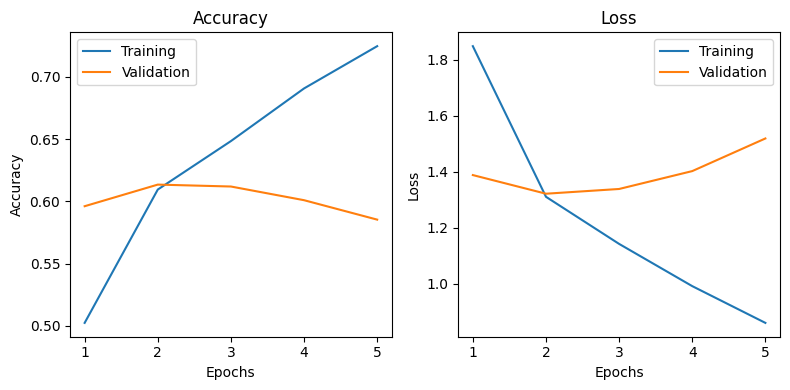

In [ ]:
lora_model_data = {'loss': [1.8487783670425415,
  1.3111143112182617,
  1.1429808139801025,
  0.9922677874565125,
  0.8610609173774719],
 'accuracy': [0.502341091632843,
  0.6094800233840942,
  0.6484245657920837,
  0.6907293200492859,
  0.7246887683868408],
 'val_loss': [1.3886702060699463,
  1.3221290111541748,
  1.3390319347381592,
  1.4028483629226685,
  1.5193214416503906],
 'val_accuracy': [0.5960862040519714,
  0.6134564876556396,
  0.6119173169136047,
  0.600923478603363,
  0.5853122472763062]}

lora_model_data = lora_model_history.history
plot_accuracy_and_loss(lora_model_data)

In [ ]:
output = lora_model.evaluate(tf_dataset_test)
accuracy_on_test_set_lora = output[1]
round(accuracy_on_test_set_lora, 4)

0.5808

Sources:
- [Multi class with Bert](https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb)

- [Dataset Preprocessing](https://huggingface.co/docs/datasets/v1.12.1/use_dataset.html)

- [Bert model layers comprehension](https://github.com/huggingface/transformers/blob/ef609958586a24b7943ad6c31184ff5a84b6f8e2/src/transformers/models/bert/modeling_tf_bert.py#L369)

- [LoRA Layer and injection](https://github.com/keras-team/keras-io/blob/master/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora.py)

- [LoRA parameters](https://arxiv.org/abs/2106.09685)

# Lime

In [ ]:
import random
# https://github.com/marcotcr/lime


class LogisticRegressionNN(tf.keras.Model):
    def __init__(self, num_features, num_classes):
        super(LogisticRegressionNN, self).__init__()
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax', input_shape=(num_features,))

    def call(self, inputs):
        return self.dense(inputs)



class Lime(object):
    def __init__(self, text, classifier, tokenizer, num_samples=1000):

        self.text = text
        self.classifier = classifier
        self.tokenizer = tokenizer
        self.num_samples = num_samples

        self.predictions_df = self.generate_predictions_df()

        self.num_features, self.num_classes = self.data_preparation()
        self.model = LogisticRegressionNN(self.num_features, self.num_classes)
        self.train_model()


    def generate_predictions_df(self):

        perturbations = self.perturbated_sample(self.text, num_samples=self.num_samples, removal_prob=0.3, random_state=1234)
        predictions_df = self.predict_perturbations(perturbations)

        return predictions_df


    def perturbated_sample(self, text, num_samples=1000, removal_prob=0.5, random_state=None):

        print(f'Generating {num_samples} perturdated samples...\n')

        if random_state is not None:
            random.seed(random_state)

        perturbed_texts = []

        for _ in range(num_samples):
            perturbed_text = self.perturbation(text, removal_prob)
            perturbed_texts.append(perturbed_text)

        return perturbed_texts


    def perturbation(self, text, removal_prob):
        words = text.split()
        perturbed_text = []
        for word in words:
            if random.random() > removal_prob:
                perturbed_text.append(word)
            else:
                perturbed_text.append('UNK')
        return ' '.join(perturbed_text)


    def predict_perturbations(self, perturbations):

        print('Predicting the samples with our model...\n')

        # Split the predictions in chucks to avoid to overload GPU.
        num_parts = 10
        part_size = len(perturbations) // num_parts
        perturbations_parts = [perturbations[i * part_size:(i + 1) * part_size] for i in range(num_parts)]
        if len(perturbations) % num_parts != 0:
            perturbations_parts[-1] += perturbations[num_parts * part_size:]

        predictions_list = []

        for part in perturbations_parts:
            inputs = self.tokenizer(part, padding='max_length', max_length=120, return_tensors="tf", truncation=True)
            predictions = self.classifier(inputs).numpy()
            for pred in predictions:
                argmax_position = np.argmax(pred)
                predictions_list.append(argmax_position)

        df = pd.DataFrame({'text': perturbations, 'prediction': predictions_list})

        return df


    def data_preparation(self):

        df = self.predictions_df
        self.model_tokenizer = Tokenizer(filters='\t\n')
        self.model_tokenizer.fit_on_texts(df['text'])
        sequences = np.array(self.model_tokenizer.texts_to_sequences(df['text']))
        prediction_labels = pd.get_dummies(df['prediction']).values

        num_features = sequences.shape[1]
        num_classes = prediction_labels.shape[1]

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(sequences, prediction_labels, test_size=0.2, random_state=1234)

        return num_features, num_classes


    def train_model(self):

        self.model.build(input_shape=(1, self.num_features))

        self.model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        self.model.summary()

        history = self.model.fit(self.X_train, self.y_train,
                    epochs=5,
                    batch_size=1,
                    validation_data=(self.X_val,self.y_val))



In [ ]:
sentence = df_train.iloc[1183].text
sentence_label = labels[df_train.iloc[1183].labels[0]]

print(f'We will use the sentence: \n{sentence} \n\nthat represent the following emotion: \n{sentence_label}')

In [ ]:
lime = Lime(text = sentence, classifier = lora_model, tokenizer= tokenizer, num_samples = 3000)

Model: "logistic_regression_nn_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            multiple                  115       
                                                                 
Total params: 115 (460.00 Byte)
Trainable params: 115 (460.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
2400/2400 [==============================] - 8s 3ms/step - loss: 2.6112 - accuracy: 0.6250 - val_loss: 0.7172 - val_accuracy: 0.8317
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.5391 - accuracy: 0.8700 - val_loss: 0.3932 - val_accuracy: 0.8783
Epoch 3/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.3225 - accuracy: 0.9029 - val_loss: 0.2768 - val_accuracy: 0.8933
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.2874 - accuracy: 0.8988 -

In [ ]:
reverse_word_index = {value: key for key, value in lime.model_tokenizer.word_index.items()}
tokenized_sentence = lime.model_tokenizer.texts_to_sequences([sentence])[0]
sentence_split = [reverse_word_index[i] for i in tokenized_sentence]

predicted_labels_values = [labels[i] for i in list(set(lime.predictions_df['prediction']))]

weights, _ = lime.model.dense.weights

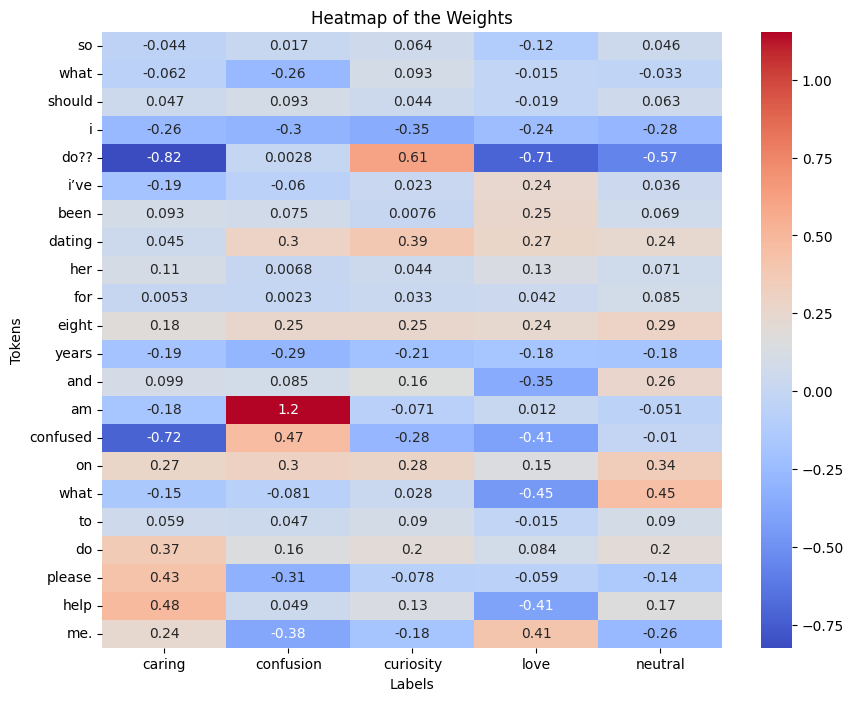

In [ ]:
weights_df = pd.DataFrame(weights.numpy(), index=sentence_split, columns=predicted_labels_values)

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(weights_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of the Weights')
plt.xlabel('Labels')
plt.ylabel('Tokens')
plt.show()